In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR

/home/brechtl/miniconda3/envs/aiframeworks/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load dataset

In [2]:
# Load and show data
math_df = pd.read_csv('../Data/Math_Test_Results_Cleaned.csv')
math_df

,Grade,Year,Number Tested,Mean Scale Score,Num Level 1,Pct Level 1,Num Level 2,Pct Level 2,Num Level 3,Pct Level 3,Num Level 4,Pct Level 4,District Number,Borough Number,School Number
0,3,2006,39,667,2,5.1,11,28.2,20,51.3,6,15.4,1,0,15
1,3,2007,31,672,2,6.5,3,9.7,22,71.0,4,12.9,1,0,15
2,3,2008,37,668,0,0.0,6,16.2,29,78.4,2,5.4,1,0,15
3,3,2009,33,668,0,0.0,4,12.1,28,84.8,1,3.0,1,0,15
4,3,2010,26,677,6,23.1,12,46.2,6,23.1,2,7.7,1,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25386,8,2008,36,567,34,94.4,2,5.6,0,0.0,0,0.0,75,1,723
25387,8,2009,31,597,18,58.1,13,41.9,0,0.0,0,0.0,75,1,723
25388,8,2010,38,598,32,84.2,6,15.8,0,0.0,0,0.0,75,1,723
25389,8,2011,32,595,24,75.0,7,21.9,1,3.1,0,0.0,75,1,723


X -> features  
y -> labels

In [3]:
X = math_df.drop('Mean Scale Score', axis=1)
y = math_df['Mean Scale Score']

### Data splitting
First of all, let's split the data into train and test data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

### Scaling
Next I will normalize the data  
Only apply a fit transform on the train data to prevent leakage in the model
I'm not going to scale the labels now but could do this if it returns a better result

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train the SVR model
I am also printing the training time for this model.  
This can be used for comparing different models or modifications to the model later on.

In [6]:
svr = SVR(kernel = 'rbf')

start = time.time()
svr.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 20.620142936706543s


In [7]:
X_train.shape

(20312, 14)

I will also make u function to print out some metrics to rate a model performance

In [8]:
def print_results(y_predicted):
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    r2 = r2_score(y_test, y_predicted)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2-score: {r2}")

### Dummy model
Before I'm going to look at the results and make any model performance assumptions, I will need a basic model to compare to.  
This is a dummy model that always return the mean of the same mean of the labels.  
Every model should perform better than this one because it's just the mean.  

In [9]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

DummyRegressor()

As you can see, the r2 score is very close to 0.  
This means that there is no variance explained in the model!

In [10]:
y_pred = dummy_regr.predict(X_test)
print_results(y_pred)

MAE: 18.084275613483413
MSE: 550.5645213553786
R2-score: -1.5951400795799486e-06


### Results
These are the result 

In [11]:
y_pred = svr.predict(X_test)
y_pred

array([706.22803684, 668.88315107, 633.83926227, ..., 667.92413375,
       700.53796027, 664.05937793])

In [12]:
print(y_test.head())
print(pd.Series(y_pred).head())

15000    710
17038    666
3439     633
8659     673
21743    672
Name: Mean Scale Score, dtype: int64
0    706.228037
1    668.883151
2    633.839262
3    676.453782
4    665.933920
dtype: float64


The average error is pretty low and we can see that this is already a pretty good model.  
The MSE is also much lower than the dummy model but I think we can still make this better!  
We did not tune any hyperparameters or applied feature reduction for the data.

In [13]:
print_results(y_pred)

MAE: 3.181354308722017
MSE: 24.272966261007497
R2-score: 0.9559125151761803


### Feature reduction (PCA)
PCA is not always useful and this is not very high dimensional data but let's give it a try.  
This first function prints the cumulative amount of variance that is explained for every PCA feature.

In [14]:
pca = PCA()
pca.fit(X_train)
print(np.cumsum(pca.explained_variance_ratio_))

[0.25236854 0.48492623 0.61481974 0.71769838 0.7981707  0.86859002
 0.91189747 0.9486366  0.97516428 0.98778364 0.9958532  0.99999978
 1.         1.        ]


Let's draw this in a plot to make it more clear how many components we should keep

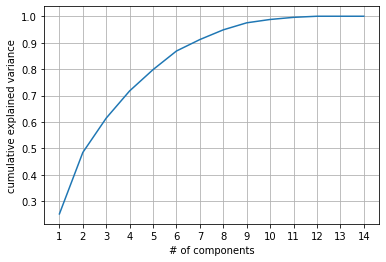

In [15]:
ex_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(ex_var)
plt.xlabel('# of components')
plt.ylabel('cumulative explained variance');
plt.xticks(np.arange(len(ex_var)), np.arange(1, len(ex_var)+1))
plt.grid()
plt.show()

As you can see, if we want to keep at least 90% variance, we should use 7 components.  
I will make a loop to find the best number of components I should use.  
I will look at the MAE and the training time for some combinations.

In [16]:
components = [5,6,7,8,9,10]

for component in components: 
    pca = PCA(n_components=component)
    pca_train = pca.fit(X_train)

    X_train_pca = pca_train.transform(X_train)
    X_test_pca = pca_train.transform(X_test)
    
    start = time.time()
    svr.fit(X_train_pca, y_train)
    stop = time.time()
    y_pred = svr.predict(X_test_pca)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{stop - start}s - MAE for {component} PCA components: {mae}")

19.016291856765747s - MAE for 5 PCA components: 3.7459847688826615
19.54123044013977s - MAE for 6 PCA components: 3.577037740660306
18.949521780014038s - MAE for 7 PCA components: 3.222861274885023
18.01684880256653s - MAE for 8 PCA components: 3.1632919116103784
19.625747680664062s - MAE for 9 PCA components: 3.1584856099114904
19.394896507263184s - MAE for 10 PCA components: 3.15759475990764


When using 8 or more components, the MAE becomes even smaller than without PCA so the model should perform better than before.  
The model becomes less complex than the original one and this can prevent overfitting + better perfromance on the test set.  
This is not always the case but in this example, it is!  

When looking at the results, I would use 8 components.  
Let's convert the data now

In [17]:
pca = PCA(n_components=8)
pca_train = pca.fit(X_train)

X_train = pca_train.transform(X_train)
X_test = pca_train.transform(X_test)

svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

In [18]:
print_results(y_pred)

MAE: 3.1632919116103793
MSE: 23.056530220119264
R2-score: 0.9581219528244317


### Hyperparameter tuning

This info about the parameters is found on the Sklearn documentation:  

__C__ -> Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
__gamma__ -> Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

Large C means large penalty for misclassification. Small C means small penalty. High C == likely to overfit!  
Gamma defines how far the influence of a single training example reaches. Low epsilon means far influence.

This grid search also makes use of cross-validation with 5 folds to prevent over-fitting.  
Because we only have 8 features, the RBF kernel would be the best choice but let's see!  

In [19]:
parameters=[
    {'C': [1,10,100],
     'kernel':['rbf'],
     'gamma': [0.001, 0.01, 0.1, 0.5, 0.8]}
]

svr = SVR()
# grid_search = GridSearchCV(estimator=svr,
#                            param_grid=parameters,
#                            cv=5,
#                            verbose=2)

# grid_search.fit(X_train,y_train)

# print(grid_search.best_estimator_)
# print(grid_search.best_params_)

The result from this grid search is  
SVR(C=100, gamma=0.1)  
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}  

When looking back at the parameters, I should increase the C value a bit more because it picked the maximum value.  
I will try to make a model with the current parameters first.

In [20]:
svr = SVR(kernel = 'rbf', C=100, gamma=0.1)

start = time.time()
svr.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

y_pred = svr.predict(X_test)
print_results(y_pred)

Training time: 92.75571084022522s
MAE: 2.3262993597174457
MSE: 11.164650740070924
R2-score: 0.9797214166256706


As you can see, the MAE is getting very good and the R2-score has reached almost '98%'  
Let's try to do the grid search one more time with some different variables to get the best result possible for this model!

In [21]:
parameters=[
    {'C': [10,100, 1000],
     'kernel':['rbf'],
     'gamma': [0.05, 0.1, 0.2]}
]

svr = SVR()
# grid_search = GridSearchCV(estimator=svr,
#                            param_grid=parameters,
#                            cv=5,
#                            verbose=2)

# grid_search.fit(X_train,y_train)

# print(grid_search.best_estimator_)
# print(grid_search.best_params_)

Results:  
SVR(C=1000, gamma=0.05)  
{'C': 1000, 'gamma': 0.05, 'kernel': 'rbf'}

As you can see the C parameter got the max value again but it took a long time to train so let's keep it at 1000 and not increase it anymore.  
I will train a new model with these new parameters:  

In [22]:
svr = SVR(kernel = 'rbf', C=1000, gamma=0.05)

start = time.time()
svr.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

y_pred = svr.predict(X_test)
print_results(y_pred)

Training time: 451.54140734672546s
MAE: 2.347010821551722
MSE: 11.315557528848034
R2-score: 0.9794473215402788


It took 5 times longer to train and it achieved almost the same accuracy and MAE.  
Because of that, I prefer the first model opposite of this model.  

### Final result visualising
I will get the right prediction values back from the best model:

In [23]:
svr = SVR(kernel = 'rbf', C=100, gamma=0.1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

In [24]:
y_pred

array([710.28838828, 667.66533595, 634.98639621, ..., 666.5317855 ,
       699.17457601, 664.77456776])

And now visualise the results  
The red line shows the perfect prediction and the dots are my predictions

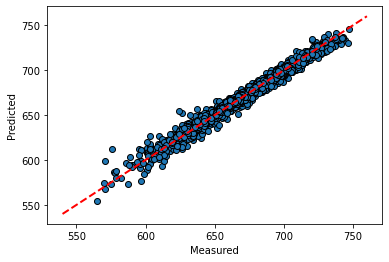

In [25]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors='black')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

My final model has a R2-score of 0.98% and MSE of 11.16  
This is much higher than I expected so let's keep it there!  
I will export this model to use it in production

### Creating a pipeline
Let's first look at the full pipeline.  
I standardized and applied PCA to the data as preprocessing.  
Than, I trained a SVR model and made my predictions.  
I will not only export the model but I will need those preprocessing steps as well to make predictions on new data.

In [40]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ("pca", PCA(n_components=8)),
      ('regression', SVR(kernel = 'rbf', C=100, gamma=0.1))
    ])

The data needs to be reloaded for this full pipeline retrain.

In [47]:
math_df = pd.read_csv('../Data/Math_Test_Results_Cleaned.csv')
X = math_df.drop('Mean Scale Score', axis=1)
y = math_df['Mean Scale Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

pipeline = pipeline.fit(X_train, y_train)

In [48]:
print('Testing score: ', pipeline.score(X_test, y_test))

Testing score:  0.979721351891418


As you can see, this pipeline is just a summary of what I did in this notebook.  
It transforms the raw data to a prediction and that's exactly what I need to deploy this model in production

### Saving the pipeline

In [49]:
import pickle

with open('model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)
    
print("Model saved!")

Model saved!
